#### Imports

In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sqlalchemy import text, create_engine

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import env

# Exercises

Clustering - DBSCAN

- Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.
- Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.


In [3]:
url = env.get_db_url("grocery_db")

engine = create_engine(url)

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(text(sql), engine.connect(), index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df.shape

(440, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 30.9 KB


In [8]:
df.columns = df.columns.str.lower()

In [9]:
df.head(1)

,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338


In [10]:
fresh_frozen_deli = df[['fresh', 'frozen', 'delicassen']]
fresh_frozen_deli

,fresh,frozen,delicassen
customer_id,,,
0,12669,214,1338
1,7057,1762,1776
2,6353,2405,7844
3,13265,6404,1788
4,22615,3915,5185
...,...,...,...
435,29703,13135,2204
436,39228,4510,2346
437,14531,437,1867


In [11]:
np_array = fresh_frozen_deli.values.astype('float32', copy=False)

In [12]:
# make the thing
mms = MinMaxScaler()

#fit/transform the thing
ffd_scaled = mms.fit_transform(np_array)

ffd_scaled

array([[0.11294005, 0.0031063 , 0.02784731],
       [0.06289903, 0.02854842, 0.03698373],
       [0.05662161, 0.03911643, 0.16355862],
       ...,
       [0.12954311, 0.00677142, 0.03888194],
       [0.09172701, 0.01664914, 0.04426366],
       [0.02482434, 0.00065742, 0.00102211]], dtype=float32)

In [13]:
fresh_frozen_deli.columns

Index(['fresh', 'frozen', 'delicassen'], dtype='object')

In [14]:
['Scaled_'+column for column in fresh_frozen_deli.columns]

['Scaled_fresh', 'Scaled_frozen', 'Scaled_delicassen']

In [15]:
scaled_columns = ['Scaled_'+column for column in fresh_frozen_deli.columns]

In [16]:
original_df = df.copy()

In [17]:
scaled_df = pd.DataFrame(ffd_scaled, columns=scaled_columns)

In [18]:
scaled_df

,Scaled_fresh,Scaled_frozen,Scaled_delicassen
0,0.112940,0.003106,0.027847
1,0.062899,0.028548,0.036984
2,0.056622,0.039116,0.163559
3,0.118254,0.104842,0.037234
4,0.201626,0.063934,0.108093
...,...,...,...
435,0.264829,0.215469,0.045912
436,0.349761,0.073713,0.048874
437,0.129543,0.006771,0.038882
438,0.091727,0.016649,0.044264


In [19]:
df.merge(scaled_df, on=df.index)

,key_0,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen,Scaled_fresh,Scaled_frozen,Scaled_delicassen
0,0,2,3,12669,9656,7561,214,2674,1338,0.112940,0.003106,0.027847
1,1,2,3,7057,9810,9568,1762,3293,1776,0.062899,0.028548,0.036984
2,2,2,3,6353,8808,7684,2405,3516,7844,0.056622,0.039116,0.163559
3,3,1,3,13265,1196,4221,6404,507,1788,0.118254,0.104842,0.037234
4,4,2,3,22615,5410,7198,3915,1777,5185,0.201626,0.063934,0.108093
...,...,...,...,...,...,...,...,...,...,...,...,...
435,435,1,3,29703,12051,16027,13135,182,2204,0.264829,0.215469,0.045912
436,436,1,3,39228,1431,764,4510,93,2346,0.349761,0.073713,0.048874
437,437,2,3,14531,15488,30243,437,14841,1867,0.129543,0.006771,0.038882
438,438,1,3,10290,1981,2232,1038,168,2125,0.091727,0.016649,0.044264


In [20]:
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [21]:
df.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen,Scaled_fresh,Scaled_frozen,Scaled_delicassen
0,2,3,12669,9656,7561,214,2674,1338,0.112940,0.003106,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.062899,0.028548,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.056622,0.039116,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.118254,0.104842,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.201626,0.063934,0.108093


### Create DBSCAN object and fit

In [22]:
# make the thing
dbsc = DBSCAN(eps = 0.10, min_samples=20)

# fit the thing
dbsc.fit(ffd_scaled)

DBSCAN(eps=0.1, min_samples=20)

### Extract labels

In [23]:
dbsc.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

### Add labels back to original df

In [24]:
df['ffd_labels'] = dbsc.labels_

In [30]:
df.sample(5)

,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen,Scaled_fresh,Scaled_frozen,Scaled_delicassen,ffd_labels
278,1,3,11693,2317,2543,5845,274,1409,0.104237,0.095654,0.029328,0
435,1,3,29703,12051,16027,13135,182,2204,0.264829,0.215469,0.045912,0
350,1,3,3521,1099,1997,1796,173,995,0.031369,0.029107,0.020693,0
23,2,3,26373,36423,22019,5154,4337,16523,0.235136,0.084298,0.344597,-1
378,1,3,3225,3294,1902,282,68,1114,0.028730,0.004224,0.023175,0


## Explore

In [31]:
df.ffd_labels.value_counts()

 0    422
-1     18
Name: ffd_labels, dtype: int64

In [32]:
for combination in itertools.combinations(fresh_frozen_deli.columns, 2):
    print(combination)

('fresh', 'frozen')
('fresh', 'delicassen')
('frozen', 'delicassen')


In [33]:
combination[0]

'frozen'

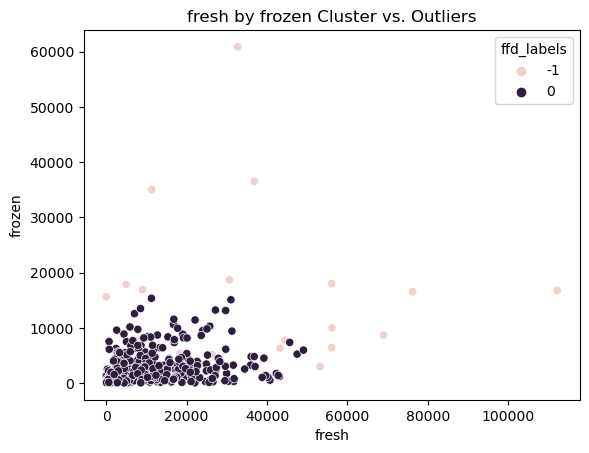

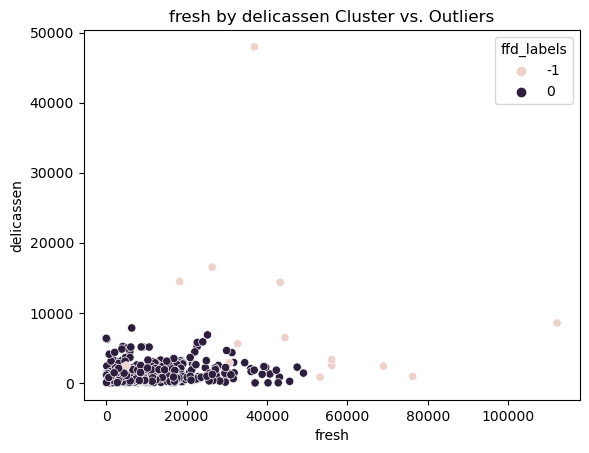

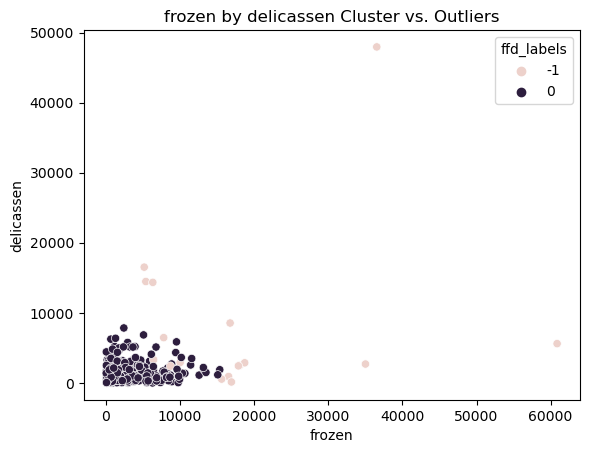

In [35]:
for combination in itertools.combinations(fresh_frozen_deli.columns, 2):
    sns.scatterplot(df[combination[0]], df[combination[1]], hue=df.ffd_labels)
    plt.title(f"{combination[0]} by {combination[1]} Cluster vs. Outliers")
    plt.show()

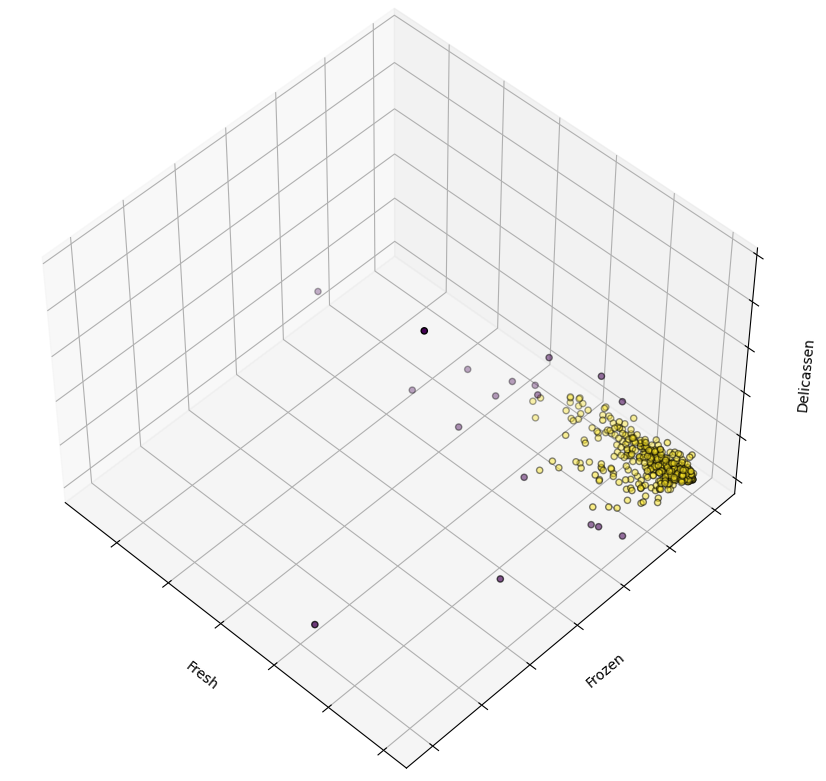

In [36]:
from mpl_toolkits.mplot3d import Axes3D

    
# Create a figure with a size of 8x8
fig = plt.figure(1, figsize=(8, 8))

# Create a 3D axes object with specified rect, elevation, and azimuth
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# Plot the points using the Fresh, Milk, and Grocery columns from the DataFrame
# Color the points based on the gmf_labels column and add black edges
ax.scatter(df.fresh, df.frozen, df.delicassen, c=df.ffd_labels, edgecolor='k')

# Remove tick labels for the x-axis, y-axis, and z-axis
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

# Set labels for the x-axis, y-axis, and z-axis
ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Delicassen')

# Display the plot
plt.show()

- Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).